# GA Project 4: West Nile virus
by: Nicholas Lim, Kwek Jun Hong, Malcolm Lau
***

[workflow gsheet](https://docs.google.com/spreadsheets/d/1-xSVNsQZX-uWmbI-ublY9yNhlsWAwXqziErKFpnPgpg/edit?usp=sharing)

# Background
***
The city of Chicago has been having to deal with seasonal upticks of incidences of the West Nile virus, and it is becoming a health hazard. We have been tasked by the Chicago Department of Public Health to come up with a predictive model to identify locations where mosquitoes would have a higher chance of carrying the disease, so that resources can be effectively allocated to stop its spread.

One of the more efficient ways to prevent the disease would be to spray Zenivex, a pesticide, and by identifying the potential hotspots we can find an effective balance between preventability and cost. To this end, we will be examining the [West Nile Virus dataset](www.kaggle.com/c/predict-west-nile-virus/data) to train a model which can effectively predict the prevalence of the virus in certain areas.



# Problem Statement
***
To train a model which can predict the prevalence of the West Nile virus amongst mosquitoes within the Chicago city area, and to run a cost-benefit analysis to determine the most effective way to apply pesticides.

# Imports

In [1]:
# fabulous four
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import datetime as dt
import warnings

warnings.filterwarnings('ignore')


# Machine Learning Libraries
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , recall_score , accuracy_score , precision_score , roc_auc_score , confusion_matrix , plot_roc_curve
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load Data

We can start by cleaning up the column names. We can create a function to clean them at one go. This function will
1. remove whitespaces at the front and end
2. change whitespaces in the middle to `_`
3. change capitals to lowercase

In [2]:
def pythonic_cols(df):
  new_cols = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).strip().lower() for name in df.columns]
  df.columns = new_cols

In [3]:
train = pd.read_csv('data/train.csv')
pythonic_cols(train)
train.head()

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
weather = pd.read_csv('data/weather.csv')
pythonic_cols(weather)
weather

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


In [5]:
spray = pd.read_csv('data/spray.csv')
pythonic_cols(spray)
spray.head()

,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [6]:
test = pd.read_csv('data/test.csv')
pythonic_cols(test)
test.head()

,id,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


# Dependent Variable

Let's first take a look at the dependent variable. We can see that it is severely imbalanced, which would be a problem later.

In [7]:
train.wnv_present.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnv_present, dtype: float64

# Feature Selection

We can choose the features that are relevant to our analysis from each dataset and combine them for easier data cleaning and analysis.

## `train`/`test` datasets

In [8]:
train.head()

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       10506 non-null  object 
 1   address                    10506 non-null  object 
 2   species                    10506 non-null  object 
 3   block                      10506 non-null  int64  
 4   street                     10506 non-null  object 
 5   trap                       10506 non-null  object 
 6   address_number_and_street  10506 non-null  object 
 7   latitude                   10506 non-null  float64
 8   longitude                  10506 non-null  float64
 9   address_accuracy           10506 non-null  int64  
 10  num_mosquitos              10506 non-null  int64  
 11  wnv_present                10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


### Address Columns

The address details are not as important to us because location information is sufficiently captured in the Lat/Long provided in the dataset. 

### `num_mosquitoes` column


            num_mosquitos  wnv_present
date                                  
2007-05-29             40            0
2007-06-05            127            0
2007-06-26            216            0
2007-06-29             85            0
2007-07-02            240            0
...                   ...          ...
2013-08-29           2645           38
2013-09-06           2510           32
2013-09-12           2210           23
2013-09-19           1030           11
2013-09-26            505            4

[95 rows x 2 columns]


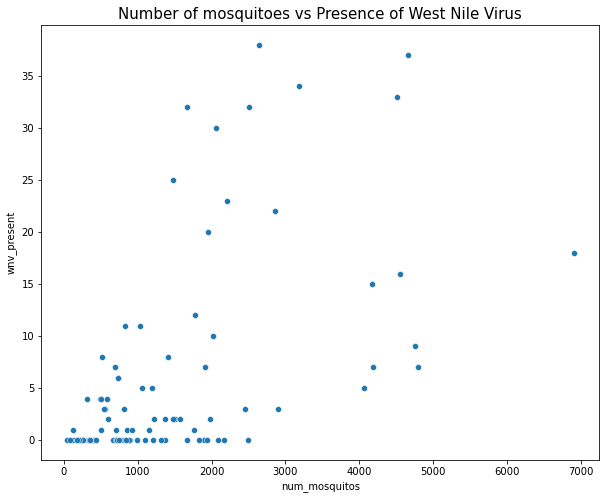

In [10]:
num_mos = train.groupby('date').sum()[['num_mosquitos','wnv_present']]
print(num_mos)

plt.figure(figsize = (10,8))
sns.scatterplot(x = 'num_mosquitos', y = 'wnv_present', data = num_mos)
plt.title('Number of mosquitoes vs Presence of West Nile Virus', fontsize = 15);

The scatter plot above shows the relatioship between the `num_mosquitoes` and `wnv_present`. It can be seen that there is no discernible pattern between the number of mosquitoes and the presence of West Nile Virus. Thus, we will drop the `num_mosquitoes` column.

### Features selected for `train`/`test`

Based on the above analysis and our domain knowledge, we will keep the features that are most relevant to us:
1. date
2. species
3. latitude
4. longitude
5. wnv_present (dependent variable)

In [11]:
train = train[['date', 'species', 'latitude', 'longitude', 'wnv_present']]
train.head()

,date,species,latitude,longitude,wnv_present
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10506 non-null  object 
 1   species      10506 non-null  object 
 2   latitude     10506 non-null  float64
 3   longitude    10506 non-null  float64
 4   wnv_present  10506 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 410.5+ KB


Whatever we do for `train`, we have to do unto `test` too, except without the dependent variable.

In [13]:
test = test[['date', 'species', 'latitude', 'longitude']]
test.head()

,date,species,latitude,longitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991
1,2008-06-11,CULEX RESTUANS,41.95469,-87.800991
2,2008-06-11,CULEX PIPIENS,41.95469,-87.800991
3,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991
4,2008-06-11,CULEX TERRITANS,41.95469,-87.800991


## `weather` datasets

In [14]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [15]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station       2944 non-null   int64  
 1   date          2944 non-null   object 
 2   tmax          2944 non-null   int64  
 3   tmin          2944 non-null   int64  
 4   tavg          2944 non-null   object 
 5   depart        2944 non-null   object 
 6   dew_point     2944 non-null   int64  
 7   wet_bulb      2944 non-null   object 
 8   heat          2944 non-null   object 
 9   cool          2944 non-null   object 
 10  sunrise       2944 non-null   object 
 11  sunset        2944 non-null   object 
 12  code_sum      2944 non-null   object 
 13  depth         2944 non-null   object 
 14  water1        2944 non-null   object 
 15  snow_fall     2944 non-null   object 
 16  precip_total  2944 non-null   object 
 17  stn_pressure  2944 non-null   object 
 18  sea_level     2944 non-null 

Taking a look at the nominal variable `code_sum`, we notice that it is a description of weather patterns captured by the weather station on a certain day. However for our case, the rest of the information suffices and thus we do not need it.

In [16]:
weather.code_sum.value_counts()

                    1609
RA                   296
RA BR                238
BR                   110
TSRA RA BR            92
                    ... 
RA DZ SN               1
TS TSRA RA FG BR       1
BR HZ VCFG             1
TS RA FG+ FG BR        1
RA SN BR               1
Name: code_sum, Length: 98, dtype: int64

We can also do a check on the precipitation columns. It seems like out of all of them, only the total precipitation column gives the most useful information - the rest are null values.

In [17]:
for col in ['depth', 'water1', 'snow_fall', 'precip_total']:
  print(col)
  print(weather[col].value_counts())
  print('===============')

depth
0    1472
M    1472
Name: depth, dtype: int64
water1
M    2944
Name: water1, dtype: int64
snow_fall
M      1472
0.0    1459
  T      12
0.1       1
Name: snow_fall, dtype: int64
precip_total
0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
3.64       1
4.73       1
1.60       1
2.24       1
1.18       1
Name: precip_total, Length: 168, dtype: int64


According to this [website](https://www.differencebetween.com/difference-between-dewpoint-and-wet-bulb-temperature/), there is a direct correlation between temperature and dewpoint which indicates the humidity. We can then remove the wet bulb temperature. Furthermore, air pressure has a significant impact on the weather patterns in the area.

Based on the above analysis, we will be choosing a few relevant columns for our analysis. The pertinent ones are:
1. station
2. date
3. tavg
4. dew_point
5. Sunrise
6. Sunset
7. precip_total
8. stn_pressure
9. sea_level
10. result_dir
11. avg_speed

In [18]:
weather = weather[['station', 'date', 'tavg', 'dew_point', 'precip_total','sunrise','sunset', 'stn_pressure', 'sea_level', 'result_dir', 'avg_speed']]
weather.head()

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,sea_level,result_dir,avg_speed
0,1,2007-05-01,67,51,0.00,0448,1849,29.10,29.82,27,9.2
1,2,2007-05-01,68,51,0.00,-,-,29.18,29.82,25,9.6
2,1,2007-05-02,51,42,0.00,0447,1850,29.38,30.09,4,13.4
3,2,2007-05-02,52,42,0.00,-,-,29.44,30.08,2,13.4
4,1,2007-05-03,56,40,0.00,0446,1851,29.39,30.12,7,11.9


# Notes from other people (TO DELETE)
- Test and train data contain multiple entries for the same locations... this could be consolidated.
- Weather contains two different stations, and dates are not standardized with train and test datasets.
- Weather data is in different dtypes.
- Spray data is for only two weeks in 2011, and a few weeks in 2013. This is not enough to see a consistent effect of spraying, and determine how much spraying really effects mosquito population.

# Data Cleaning

Our data cleaning will involve two steps:
1. imputing missing values
2. changing datatypes

## `train` dataset

We will first examine the `train` dataset and the datatypes of the features.

In [19]:
train.head()

,date,species,latitude,longitude,wnv_present
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10506 non-null  object 
 1   species      10506 non-null  object 
 2   latitude     10506 non-null  float64
 3   longitude    10506 non-null  float64
 4   wnv_present  10506 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 410.5+ KB


### Missing values

It seems like everything is in order and there are no null values, but that is a cruel trick. According to the [data dictionary](https://www.kaggle.com/c/predict-west-nile-virus/data?select=noaa_weather_qclcd_documentation.pdf), there are three types of missing values:
1. `*`: Not all stations report snow totals
2. `M`: Missing Data, or data that are not normally reported for the station
3. `-`: values not available for sunrise/sunset

And additional `T` values for trace amounts. We can write a function to replace them with suitable values.

In [21]:
 def missing_no(df):
    df.replace(r'\s*M+\s*', 0, regex=True, inplace=True)
    df.replace('-', 0, inplace=True)
    df.replace('*', 0, inplace=True)
    df.replace(r'^\s*T+(?!\d)+', 1e-5, regex=True, inplace=True)

missing_no(weather)

In [22]:
weather.head()

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,sea_level,result_dir,avg_speed
0,1,2007-05-01,67,51,0.00,0448,1849,29.10,29.82,27,9.2
1,2,2007-05-01,68,51,0.00,0,0,29.18,29.82,25,9.6
2,1,2007-05-02,51,42,0.00,0447,1850,29.38,30.09,4,13.4
3,2,2007-05-02,52,42,0.00,0,0,29.44,30.08,2,13.4
4,1,2007-05-03,56,40,0.00,0446,1851,29.39,30.12,7,11.9


In [23]:
missing_no(test)
test

,date,species,latitude,longitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.954690,-87.800991
1,2008-06-11,CULEX RESTUANS,41.954690,-87.800991
2,2008-06-11,CULEX PIPIENS,41.954690,-87.800991
3,2008-06-11,CULEX SALINARIUS,41.954690,-87.800991
4,2008-06-11,CULEX TERRITANS,41.954690,-87.800991
...,...,...,...,...
116288,2014-10-02,CULEX SALINARIUS,41.925652,-87.633590
116289,2014-10-02,CULEX TERRITANS,41.925652,-87.633590
116290,2014-10-02,CULEX TARSALIS,41.925652,-87.633590
116291,2014-10-02,UNSPECIFIED CULEX,41.925652,-87.633590


### Changing dtypes

From the information table, some of the columns aren't in the right dtype. We can create a function to correct all the wrong datatypes.

In [24]:
def changing_types(df):
    df['date'] = pd.to_datetime(df['date'])
    try:
        df['tavg'] = df['tavg'].astype(int)
        df['tavg'] = df['tavg'].astype(int)
        df['avg_speed'] = df['avg_speed'].astype(float)
        df['avg_speed'] = df['avg_speed'].astype(float)
        df['stn_pressure'] = df['stn_pressure'].astype(float)
        df['precip_total'] = df['precip_total'].astype(float)
        df['precip_total'] = df['precip_total'].astype(float)
        df.info()
    except:
        pass

In [25]:
changing_types(weather)
changing_types(train)
changing_types(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station       2944 non-null   int64         
 1   date          2944 non-null   datetime64[ns]
 2   tavg          2944 non-null   int32         
 3   dew_point     2944 non-null   int64         
 4   precip_total  2944 non-null   float64       
 5   sunrise       2944 non-null   object        
 6   sunset        2944 non-null   object        
 7   stn_pressure  2944 non-null   float64       
 8   sea_level     2944 non-null   object        
 9   result_dir    2944 non-null   int64         
 10  avg_speed     2944 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3), object(3)
memory usage: 241.6+ KB


### Creating `year`, `month` and `week` columns

Additional time related columns would be created from the `date` columns.

In [26]:
def preprocess_date(df):
    """Function to create additional time related columns"""
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['week_of_year'] = pd.to_datetime(df['date']).dt.isocalendar().week
    return df

In [27]:
# create the columns for both train and test datasets
preprocess_date(train)
preprocess_date(test)
preprocess_date(weather)

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,sea_level,result_dir,avg_speed,year,month,week_of_year
0,1,2007-05-01,67,51,0.00000,0448,1849,29.10,29.82,27,9.2,2007,5,18
1,2,2007-05-01,68,51,0.00000,0,0,29.18,29.82,25,9.6,2007,5,18
2,1,2007-05-02,51,42,0.00000,0447,1850,29.38,30.09,4,13.4,2007,5,18
3,2,2007-05-02,52,42,0.00000,0,0,29.44,30.08,2,13.4,2007,5,18
4,1,2007-05-03,56,40,0.00000,0446,1851,29.39,30.12,7,11.9,2007,5,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,45,34,0.00000,0,0,29.42,30.07,29,9.0,2014,10,44
2940,1,2014-10-30,42,34,0.00000,0622,1649,29.34,30.09,24,5.5,2014,10,44
2941,2,2014-10-30,45,35,0.00001,0,0,29.41,30.10,23,6.5,2014,10,44
2942,1,2014-10-31,40,25,0.03000,0623,1647,29.49,30.20,34,22.9,2014,10,44


from scipy.stats import normaltest 

normaltest(train['tavg'])

## Feature Engineering

1. Humidity - Dew Point measures the xxxxxx. Therefore, the closer the dry bulb temperature (Tavg) with Dew Point, the more humid the atmosphere is.
2. Daylight Hours - 

In [28]:
# Only station 1 records sunrise and sunset hours.
weather_1 = weather.loc[weather['station'] == 1]

print(weather_1['sunset'].unique())

# creating the daylight_hours column
weather_1['sunset'] = weather_1['sunset'].map(lambda x : (str(int(x[0:2]) + 1) + '00') if x[2:4] == '60' else x)

weather_1['sunrise_time'] = weather_1['sunrise'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_1['sunset_time'] = weather_1['sunset'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_1['daylight_hours'] = (weather_1['sunset_time'] - weather_1['sunrise_time']).map(lambda x : round((x.seconds/3600),2))

weather = weather.merge(weather_1[['date','daylight_hours']], on='date')

['1849' '1850' '1851' '1852' '1853' '1855' '1856' '1857' '1858' '1859'
 '1860' '1901' '1902' '1903' '1904' '1905' '1906' '1907' '1908' '1909'
 '1910' '1911' '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919'
 '1920' '1921' '1922' '1923' '1924' '1925' '1926' '1927' '1928' '1929'
 '1930' '1931' '1900' '1854' '1848' '1846' '1845' '1843' '1842' '1840'
 '1839' '1837' '1835' '1834' '1832' '1831' '1829' '1827' '1826' '1824'
 '1822' '1821' '1819' '1817' '1815' '1814' '1812' '1810' '1809' '1807'
 '1805' '1803' '1760' '1758' '1756' '1755' '1753' '1751' '1749' '1748'
 '1746' '1744' '1742' '1741' '1739' '1737' '1735' '1734' '1732' '1730'
 '1729' '1727' '1725' '1724' '1722' '1720' '1719' '1717' '1715' '1714'
 '1712' '1711' '1709' '1707' '1706' '1704' '1703' '1701' '1660' '1658'
 '1657' '1656' '1654' '1653' '1651' '1650' '1649' '1647']


There were incorrect records where the '60' minutes were recorded for Sunset. We will correct these mistakes and create a new column called daylight_hours and append it to weather.

In [29]:
# creating the humidity column
tavg_celsius = ((weather['tavg'] - 32) * 5 / 9)
dew_point_celsius = ((weather['dew_point'] - 32) * 5 / 9)
vap_press_sat = np.exp((17.625 * tavg_celsius) / (tavg_celsius + 243.04))
vap_press_act = np.exp((17.625 * dew_point_celsius) / (dew_point_celsius + 243.04))
r_humidity = round(((vap_press_act / vap_press_sat) * 100),2)

weather['r_humidity'] = r_humidity
weather.head()

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,sea_level,result_dir,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,1,2007-05-01,67,51,0.0,0448,1849,29.10,29.82,27,9.2,2007,5,18,14.02,56.44
1,2,2007-05-01,68,51,0.0,0,0,29.18,29.82,25,9.6,2007,5,18,14.02,54.53
2,1,2007-05-02,51,42,0.0,0447,1850,29.38,30.09,4,13.4,2007,5,18,14.05,71.20
3,2,2007-05-02,52,42,0.0,0,0,29.44,30.08,2,13.4,2007,5,18,14.05,68.61
4,1,2007-05-03,56,40,0.0,0446,1851,29.39,30.12,7,11.9,2007,5,18,14.08,54.87


# Exploratory Data Analysis

## Distribution of Weather Information for Stations 1 & 2

From the summary statistics below, the distributions of weather information from Stations 1 & 2 are very similar. The measurements will be consolidated into a single measure using the means of the measures of both stations for each day.

In [30]:
display(weather[weather['station']==1].describe())
display(weather[weather['station']==2].describe())

,station,tavg,dew_point,precip_total,stn_pressure,result_dir,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
count,1472.0,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,1.0,66.606658,53.377717,0.134539,29.214457,17.656250,8.570788,2010.500000,7.500000,30.838995,13.669728,63.403736
std,0.0,10.511437,10.670263,0.421066,1.089193,10.222077,3.187250,2.292067,1.710526,7.602052,1.489801,11.318025
min,1.0,36.000000,22.000000,0.000000,0.000000,1.000000,1.900000,2007.000000,5.000000,17.000000,10.400000,32.110000
25%,1.0,60.000000,46.000000,0.000000,29.160000,7.000000,6.200000,2008.750000,6.000000,24.000000,12.515000,55.355000
50%,1.0,68.000000,54.000000,0.000000,29.260000,19.500000,8.100000,2010.500000,7.500000,31.000000,14.235000,63.130000
75%,1.0,75.000000,61.250000,0.060000,29.350000,26.000000,10.400000,2012.250000,9.000000,37.000000,14.955000,70.890000
max,1.0,93.000000,75.000000,6.860000,29.790000,36.000000,26.300000,2014.000000,10.000000,44.000000,15.230000,103.700000


,station,tavg,dew_point,precip_total,stn_pressure,result_dir,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
count,1472.0,1472.000000,1472.000000,1472.000000,1472.000000,1472.00000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,2.0,67.370924,53.538043,0.127943,29.274823,17.33356,8.572622,2010.500000,7.500000,30.838995,13.669728,67.495482
std,0.0,12.023190,10.683121,0.363335,1.091259,9.90345,3.128732,2.292067,1.710526,7.602052,1.489801,82.207548
min,2.0,0.000000,23.000000,0.000000,0.000000,1.00000,0.000000,2007.000000,5.000000,17.000000,10.400000,29.990000
25%,2.0,61.000000,46.000000,0.000000,29.230000,8.00000,6.300000,2008.750000,6.000000,24.000000,12.515000,53.187500
50%,2.0,70.000000,55.000000,0.000000,29.320000,19.00000,8.100000,2010.500000,7.500000,31.000000,14.235000,60.635000
75%,2.0,76.000000,62.000000,0.050000,29.410000,24.00000,10.400000,2012.250000,9.000000,37.000000,14.955000,68.660000
max,2.0,94.000000,74.000000,4.730000,29.860000,36.00000,22.600000,2014.000000,10.000000,44.000000,15.230000,1643.760000


In [31]:
weather_agg = weather.groupby('date').mean()
weather_agg.drop(columns=['station'], inplace=True)
weather_agg.reset_index(inplace=True)
weather_agg.head()

,date,tavg,dew_point,precip_total,stn_pressure,result_dir,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2007-05-01,67.5,51.0,0.000000,29.140,26.0,9.40,2007.0,5.0,18.0,14.02,55.485
1,2007-05-02,51.5,42.0,0.000000,29.410,3.0,13.40,2007.0,5.0,18.0,14.05,69.905
2,2007-05-03,57.0,40.0,0.000000,29.425,6.5,12.55,2007.0,5.0,18.0,14.08,52.965
3,2007-05-04,29.0,41.5,0.000005,29.335,7.5,10.60,2007.0,5.0,18.0,14.13,324.475
4,2007-05-05,60.0,38.5,0.000010,29.430,7.0,11.75,2007.0,5.0,18.0,14.17,44.845


The weather and train DataFrames will be merged on the dates when there are records of testing

In [32]:
# merging the weather_agg and train columns + deleting duplicated columns + renaming columns

train = train.merge(weather_agg, on='date')
test = test.merge(weather_agg, on ='date')

train.drop(columns=['year_x', 'month_x', 'week_of_year_x'],inplace=True)
train.rename(columns={'year_y':'year', 'month_y':'month','week_of_year_y':'week_of_year'},inplace=True)
test.drop(columns=['year_x', 'month_x', 'week_of_year_x'],inplace=True)
test.rename(columns={'year_y':'year', 'month_y':'month','week_of_year_y':'week_of_year'},inplace=True)
train.head()

,date,species,latitude,longitude,wnv_present,tavg,dew_point,precip_total,stn_pressure,result_dir,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,75.5,58.5,0.0,29.415,17.0,6.95,2007.0,5.0,22.0,14.93,55.615
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0,75.5,58.5,0.0,29.415,17.0,6.95,2007.0,5.0,22.0,14.93,55.615
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0,75.5,58.5,0.0,29.415,17.0,6.95,2007.0,5.0,22.0,14.93,55.615
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,75.5,58.5,0.0,29.415,17.0,6.95,2007.0,5.0,22.0,14.93,55.615
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0,75.5,58.5,0.0,29.415,17.0,6.95,2007.0,5.0,22.0,14.93,55.615


In [33]:
test.head()

,date,species,latitude,longitude,tavg,dew_point,precip_total,stn_pressure,result_dir,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,18.0,10.2,2008.0,6.0,24.0,15.17,50.79
1,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,18.0,10.2,2008.0,6.0,24.0,15.17,50.79
2,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,75.0,55.5,0.0,29.31,18.0,10.2,2008.0,6.0,24.0,15.17,50.79
3,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,75.0,55.5,0.0,29.31,18.0,10.2,2008.0,6.0,24.0,15.17,50.79
4,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,18.0,10.2,2008.0,6.0,24.0,15.17,50.79


## Temporal Trends for Testing 


### Macro Trends by Year

(to be revised)
From Fig 1, we can observe that 2007 & 2013 showed a marked increase in WNV cases over 2009 & 2011. Fig 2 below shows that increase in cases recorded in 2007 likely resulted from increased testing efforts as the number of tests performed were much higher than the proceeding years, testing efforts from 2009 onwards were quite similar and the spike in WNV cases in 2013 is likely to have arisen due to other factors, not because more tests were performed. 

Text(0.5, 1.0, 'Fig 1: Average Number of WNV Cases by Year from Odd Years 2007-2013')

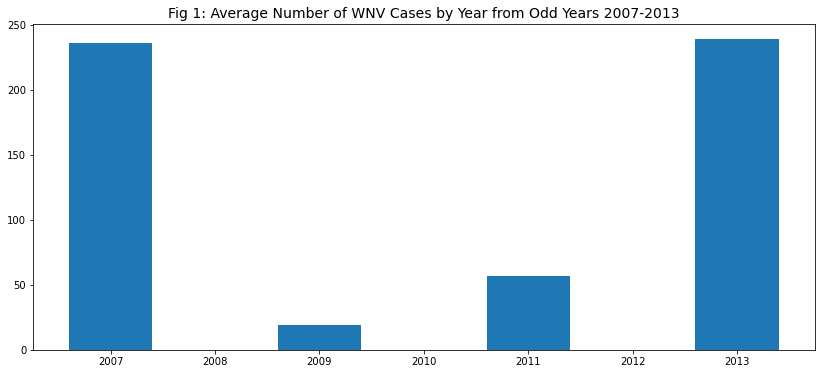

In [34]:
wnv_avg = train.groupby(['year'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(wnv_avg['year'], wnv_avg['wnv_present'])
plt.title('Fig 1: Average Number of WNV Cases by Year from Odd Years 2007-2013', fontsize=14)

Text(0.5, 1.0, 'Fig 2: Number of Records by Year from Odd Years 2007-2013')

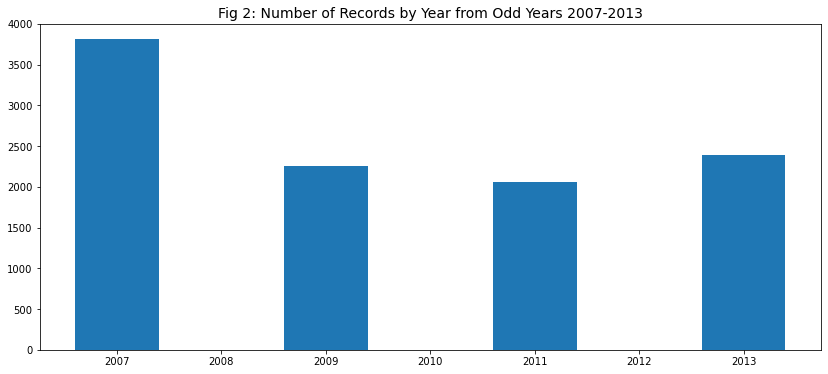

In [35]:
wnv_avg = train.groupby(['year'], as_index=False)['date'].count()
plt.figure(figsize=(14,6))
plt.bar(wnv_avg['year'], wnv_avg['date'])
plt.title('Fig 2: Number of Records by Year from Odd Years 2007-2013', fontsize=14)

### Weather Trends on WNV Cases

Text(0.5, 1.0, 'Fig 3: Average Temperature vs WNV Cases in Odd Years from 2007-2013')

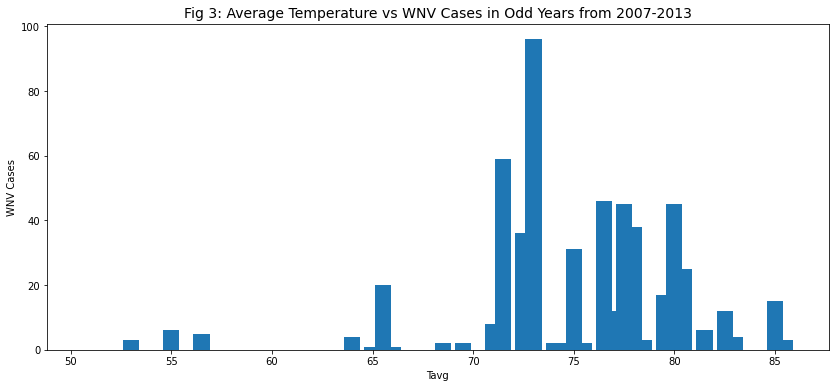

In [36]:
temp_avg = train.groupby(['tavg'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(temp_avg['tavg'], temp_avg['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('Tavg')
plt.title('Fig 3: Average Temperature vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

Text(0.5, 1.0, 'Fig 4: Average Wind Speed (mi/h) vs WNV Cases in Odd Years from 2007-2013')

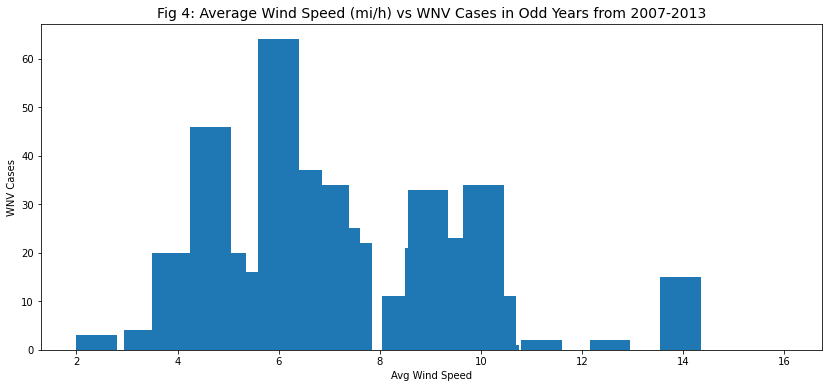

In [37]:
wind_avg = train.groupby(['avg_speed'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(wind_avg['avg_speed'], wind_avg['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('Avg Wind Speed')
plt.title('Fig 4: Average Wind Speed (mi/h) vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

Text(0.5, 1.0, 'Fig 5: Average Pressure (Hg) vs WNV Cases in Odd Years from 2007-2013')

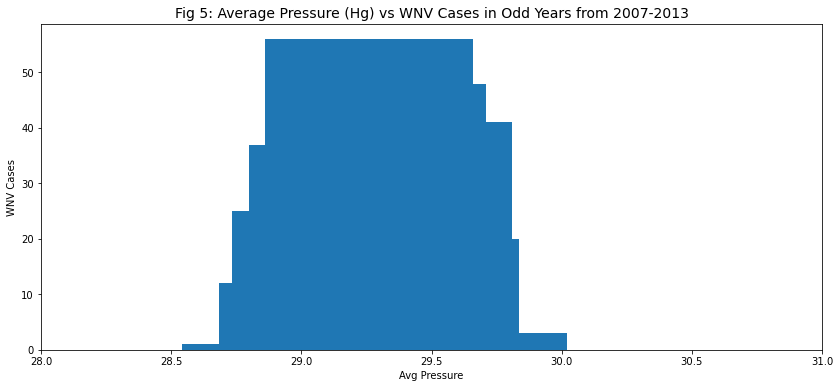

In [38]:
stn_avg = train.groupby(['stn_pressure'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(stn_avg['stn_pressure'], stn_avg['wnv_present'])
plt.xlim((28,31))
plt.ylabel('WNV Cases')
plt.xlabel('Avg Pressure')
plt.title('Fig 5: Average Pressure (Hg) vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

Text(0.5, 1.0, 'Fig 6: Daylight Hours (hrs) vs WNV Cases in Odd Years from 2007-2013')

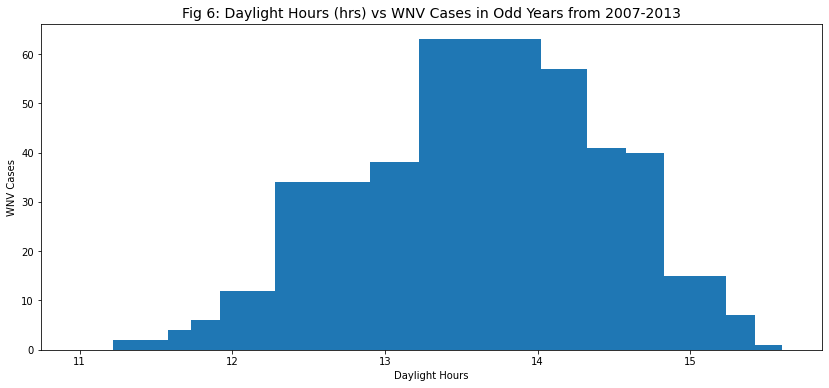

In [39]:
daylight_avg = train.groupby(['daylight_hours'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(daylight_avg['daylight_hours'], daylight_avg['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('Daylight Hours')
plt.title('Fig 6: Daylight Hours (hrs) vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

### Seasonal Trends

(To be revised) The trend of a gradual increase in WNV cases from Week 30 to Week 40 was not due to increase in testing efforts

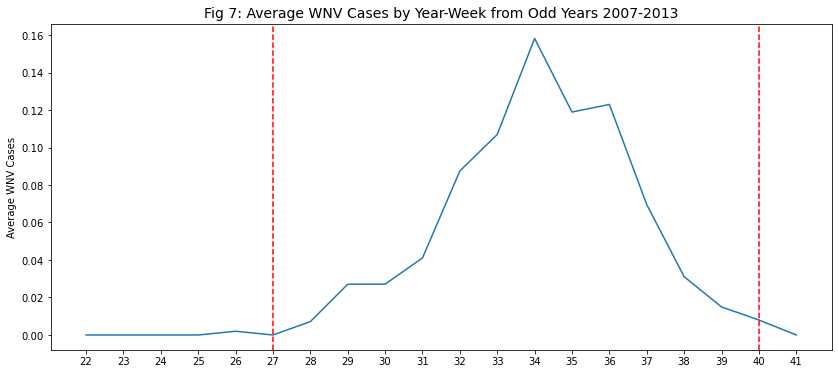

In [40]:
wnv_avg = train.groupby(['week_of_year'], as_index=False)['wnv_present'].mean()
plt.figure(figsize=(14,6))
plt.plot(wnv_avg['week_of_year'], wnv_avg['wnv_present'])
plt.xticks(range(22,42))
plt.ylabel('Average WNV Cases') 
plt.title('Fig 7: Average WNV Cases by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')

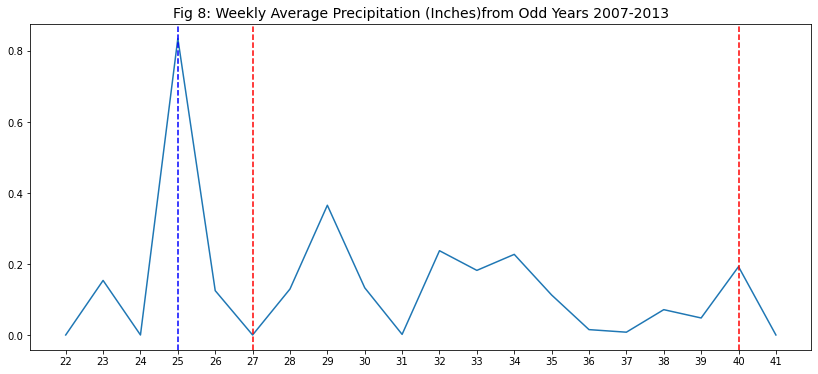

In [41]:
precip_avg = train.groupby(['week_of_year'], as_index=False)['precip_total'].mean()
plt.figure(figsize=(14,6))
plt.plot(precip_avg['week_of_year'], precip_avg['precip_total'])
plt.xticks(range(22,42))
plt.title('Fig 8: Weekly Average Precipitation (Inches)from Odd Years 2007-2013', fontsize=14)

plt.axvline(25, linestyle='--', color='b')
plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')

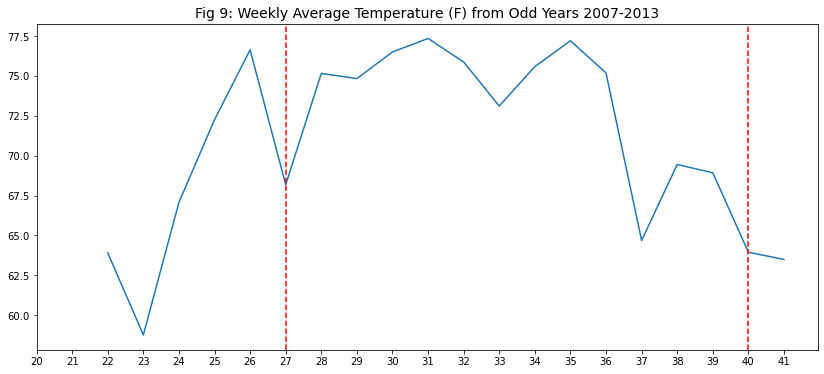

In [42]:
temp_avg = train.groupby(['week_of_year'], as_index=False)['tavg'].mean()
plt.figure(figsize=(14,6))
plt.plot(temp_avg['week_of_year'], temp_avg['tavg'])
plt.xticks(range(20,42))
plt.title('Fig 9: Weekly Average Temperature (F) from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')

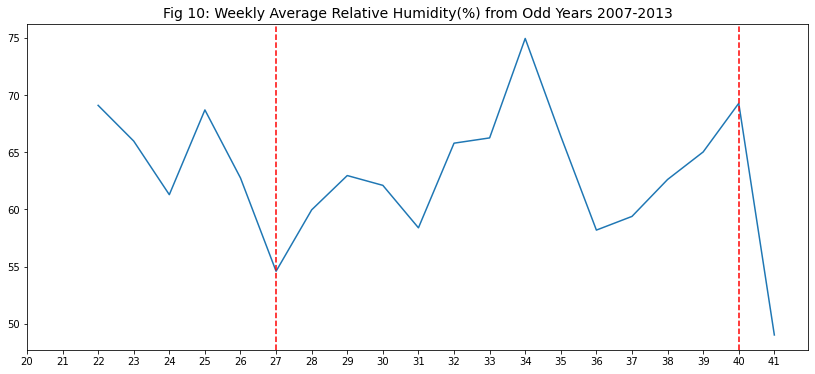

In [43]:
rh_avg = train.groupby(['week_of_year'], as_index=False)['r_humidity'].mean()
plt.figure(figsize=(14,6))
plt.plot(rh_avg['week_of_year'], rh_avg['r_humidity'])
plt.xticks(range(20,42))
plt.title('Fig 10: Weekly Average Relative Humidity(%) from Odd Years 2007-2013', fontsize=14)
plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')

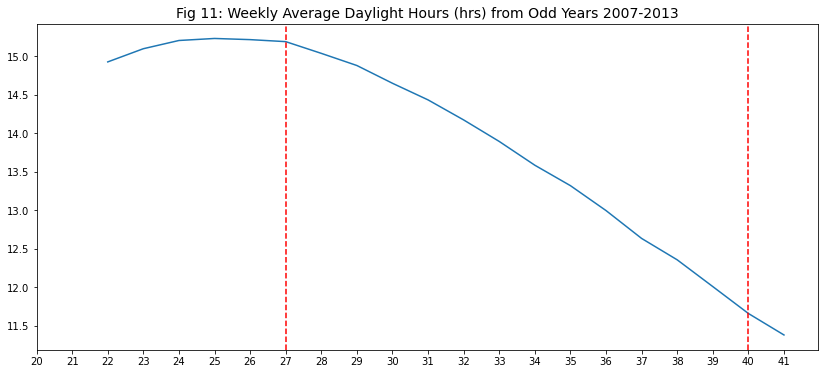

In [44]:
daylight_avg = train.groupby(['week_of_year'], as_index=False)['daylight_hours'].mean()
plt.figure(figsize=(14,6))
plt.plot(daylight_avg['week_of_year'], daylight_avg['daylight_hours'])
plt.xticks(range(20,42))
plt.title('Fig 11: Weekly Average Daylight Hours (hrs) from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')

### WNV Cases by Mosquito Species

(to be revised)

                  species  wnv_present
0         CULEX ERRATICUS            0
1           CULEX PIPIENS          240
2  CULEX PIPIENS/RESTUANS          262
3          CULEX RESTUANS           49
4        CULEX SALINARIUS            0
5          CULEX TARSALIS            0
6         CULEX TERRITANS            0


Text(0.5, 1.0, 'Fig 12: WNV Cases by Mosquito Species from Odd Years 2007-2013')

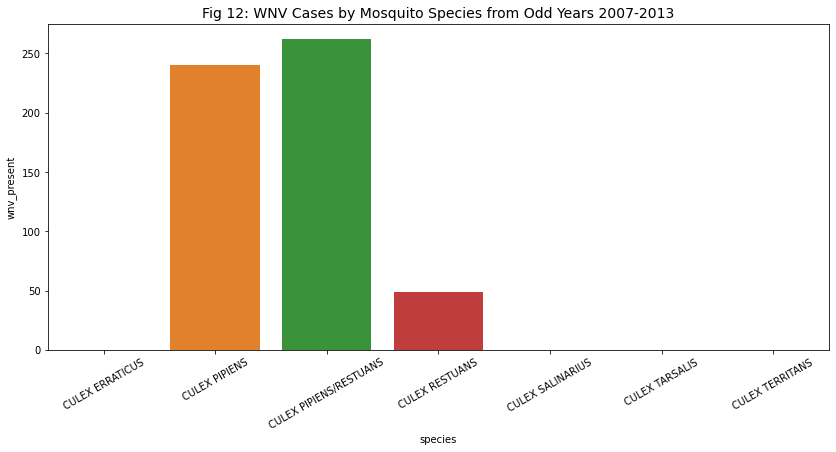

In [45]:
species = train.groupby(['species'], as_index=False)['wnv_present'].sum()
print(species)
plt.figure(figsize=(14,6))
sns.barplot(species['species'], species['wnv_present'])
plt.xticks(rotation=30)
plt.title('Fig 12: WNV Cases by Mosquito Species from Odd Years 2007-2013', fontsize=14)

In [46]:
minority_species = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
train['species'] = train['species'].apply(lambda x: 'OTHERS' if x not in minority_species else x)
train = pd.get_dummies(train, columns=['species'], drop_first=True)

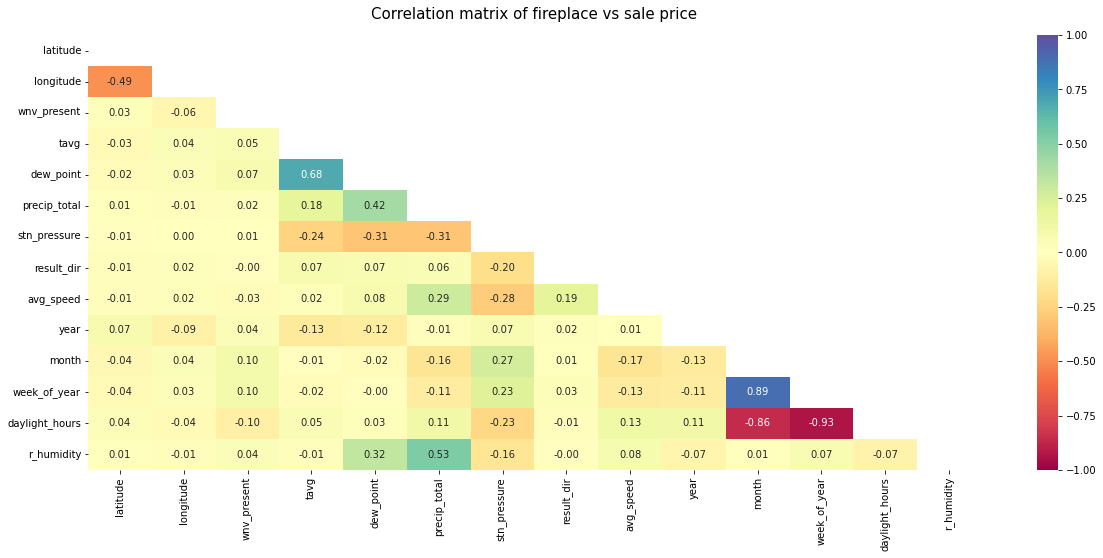

In [99]:
corr = train.corr(method='kendall')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(
    corr, annot=True, fmt=".2f", mask=mask, cmap="Spectral", vmax=1, vmin=-1
)
heatmap.set_title(
    "Correlation matrix of fireplace vs sale price", fontdict={"fontsize": 15}, pad=16
);

- OHE species
- corr matrix
- boxplot

# Modeling
***
The following models would be used:

|                |                  Models                 |
|:--------------:|:---------------------------------------:|
| Baseline Model |               BernoulliNB               |
|     Model 1    |         Random Forest Classifier        |
|     Model 2    |   Random Forest Classifier with SMOTE   |
|     Model 3    |       Gradient Boosting Classifier      |
|     Model 4    | Gradient Boosting Classifier with SMOTE |
|     Model 5    |              XGBClassifier              |
|     Model 6    |         XGBClassifier with SMOTE        |



Baseline: BernoulliNB. 
Candidate Models: 
* for each model, run with/without SMOTE 
- Random Forest
- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [XGBClassifier](https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390)
  - [feature importance in xgboost](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/) 

- good to haves:
  - [ADASYN](https://towardsdatascience.com/adasyn-adaptive-synthetic-sampling-method-for-imbalanced-data-602a3673ba16) (instead of SMOTE)
  - [neural networks](https://www.analyticsvidhya.com/blog/2021/11/neural-network-for-classification-with-tensorflow/)

Below is a template for `columntransformer` to deal with the categorical and numerican data separately

In [ ]:
# define the numerical and categorical columns

numerical_cols = ['tavg_1', 'dew_point_1', 'precip_total_1', 'stn_pressure_1', 'sea_level_1',\
                  'result_dir_1', 'avg_speed_1', 'tavg_2', 'dew_point_2', 'precip_total_2',\
                  'stn_pressure_2', 'sea_level_2', 'result_dir_2', 'avg_speed_2']
categorical_cols = ['species']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown = "ignore")),
    ]
)

# Bundle preprocessing for numerical and categorical data
transformer = ColumnTransformer(
    transformers = [
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [ ]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(X_train, X_test, y_train, y_test, mod, mod_params = {}, grid_search = False):
    
    # Initial dictionary to hold model results
    time_start = time.time()
    results = {}
    
    pipe = Pipeline([
            ('t', transformer),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid = mod_params, cv = 5, verbose = 1, scoring = 'roc_auc', n_jobs = 4)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('---Best Parameters---')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('---Metrics---')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print()
    time_end =  time.time()
    print(f"Time Taken: {round((time_end - time_start), 2)}s")
    return pipe

## Get the X, y data

In [ ]:
X = train.drop(['date', 'wnv_present'], axis = 1)
y = train['wnv_present']

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
y.value_counts(normalize = True)

## Train, test, split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# Instiantiate the models
models = {'nb': BernoulliNB(),
          'rf': RandomForestClassifier(random_state = 42),
          'gb': GradientBoostingClassifier(random_state = 42),
          'xgb': XGBClassifier(random_state = 42)
        }

### Baseline Model

In [ ]:
nb = run_model(X_train, X_test, y_train, y_test, 'nb')

### Candidate Models without SMOTE 

In [ ]:
# model params

rf_params = {'rf__n_estimators': [50, 100, 150, 200],
             'rf__max_depth': [5, 10, 15, 20],
             'rf__min_samples_leaf': [2, 5, 10],
             'rf__class_weight' : ['balanced', 'balanced_subsample']
            }

gb_params = {'gb__max_depth': [2, 3, 4, 5],
             'gb__n_estimators': [75, 100, 150, 200, 300],
             'gb__learning_rate': [.05, .08, .1]
            }
    
xgb_params = {'xgb__max_depth' : [4, 5, 6, 7],
              'xgb__learning_rate' : [0.1, 0.3, 0.5, 0.7],
              'xgb__n_estimators' : [75, 100, 150, 200, 300],
              'xgb__colsample_bytree' : [0.1, 0.5, 1],
              'xgb__subsample' : [0.5, 0.7, 1]
             }

In [ ]:
%%time

rf = run_model(X_train, X_test, y_train, y_test, 'rf', rf_params, grid_search = True)
print()
gb = run_model(X_train, X_test, y_train, y_test, 'gb', gb_params, grid_search = True)
print()
xgb = run_model(X_train, X_test, y_train, y_test, 'xgb', xgb_params, grid_search = True)


### SMOTE 

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X,y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, stratify = y, random_state = 42)

# Conclusion